# GMT PSF & image simulator

In [39]:
# Load python librairies
import os
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
# Ignore some unrelated deprecation warnings from current version of Matplotlib
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

Populating the interactive namespace from numpy and matplotlib


In [3]:
import poppy
from astropy import units as u

<AxesSubplot:title={'center':'Transmittance for unnamed'}, ylabel='[meters]'>

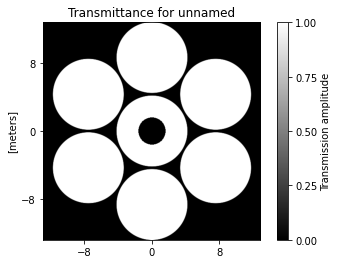

In [34]:
# -----Build GMT aperture-----
primary = poppy.optics.MultiCircularAperture(rings=1, segment_radius=8.365*u.m/2, gap=0.293*u.m)
secondary = poppy.SecondaryObscuration(secondary_radius=3.2*u.m/2)
gmt_aperture = poppy.CompoundAnalyticOptic(opticslist = [primary, secondary])
gmt_aperture.display(what="intensity", colorbar_orientation="vertical")

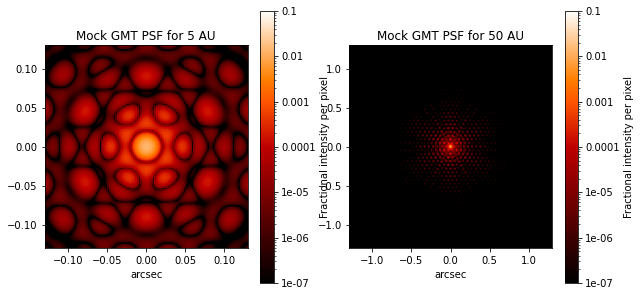

In [113]:
# -----Calculate GMT PSF-----
osys1 = poppy.OpticalSystem()
osys1.add_pupil(gmt_aperture)
osys1.add_detector(pixelscale=0.005, fov_arcsec=0.26)  # in arcsec
gmt_psf1 = osys1.calc_psf(2e-6)

osys2 = poppy.OpticalSystem()
osys2.add_pupil(gmt_aperture)
osys2.add_detector(pixelscale=0.005, fov_arcsec=2.6)  # in arcsec
gmt_psf2 = osys2.calc_psf(2e-6)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
poppy.display_psf(gmt_psf1, scale='log', ax=ax1, title="Mock GMT PSF for 5 AU")
poppy.display_psf(gmt_psf2, scale='log', ax=ax2, title="Mock GMT PSF for 50 AU")

pixel scale 1 is 0.00500006684581344 arcsec/pix
pixel scale 2 is 0.00500006684581344 arcsec/pix


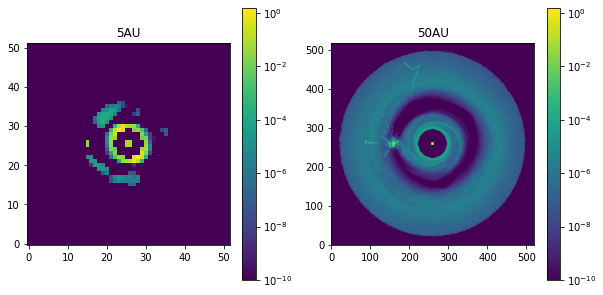

In [112]:
# -----Import fits image-----
from astropy.io import fits

with fits.open("image2_npix52.fits") as hdulist:
    hdr1 = hdulist[0].header
    image1 = hdulist[0].data[0]

with fits.open("image50au2_npix520.fits") as hdulist:
    hdr2 = hdulist[0].header
    image2 = hdulist[0].data[0]

cmap = plt.cm.viridis
cmap.set_bad(color=cmap(0))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
im1=ax1.imshow(image1, cmap=cmap, norm=LogNorm(vmin=1e-10))
ax1.set_title("5AU")
fig.colorbar(im1, ax=ax1)

im2=ax2.imshow(image2, cmap=cmap, norm=LogNorm(vmin=1e-10))
ax2.set_title("50AU")
fig.colorbar(im1, ax=ax2)

print("pixel scale 1 is", hdr1['CDELT1'] * -3600, "arcsec/pix")
print("pixel scale 2 is", hdr2['CD1_1'] * -3600, "arcsec/pix")

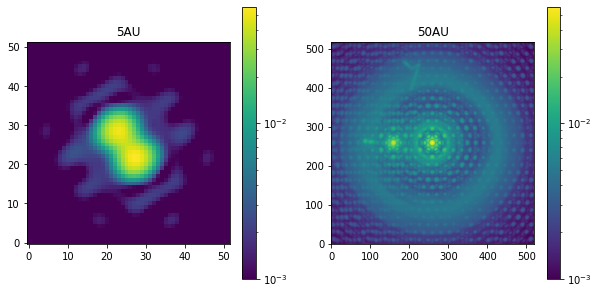

In [137]:
# -----Convolve image with PSF-----
from astropy.convolution import *
conv_image1 = convolve_fft(image1, gmt_psf1[0].data, boundary='wrap')
conv_image2 = convolve_fft(image2, gmt_psf2[0].data, boundary='fill')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
im1=ax1.imshow(conv_image1, cmap=cmap, norm=LogNorm(vmin=1e-3))
ax1.set_title("5AU")
fig.colorbar(im1, ax=ax1)

im2=ax2.imshow(conv_image2, cmap=cmap, norm=LogNorm())
ax2.set_title("50AU")
fig.colorbar(im1, ax=ax2)

(0, 0)

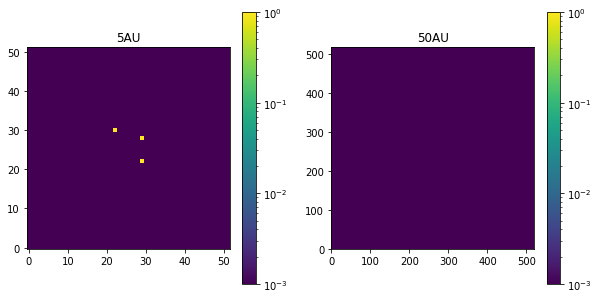

In [143]:
#-----Add noise to image-----

# Poisson noise
noise_mask1 = np.random.poisson(lam=conv_image1, size=None)
noisy_img1 = conv_image1 + noise_mask1

noise_mask2 = np.random.poisson(conv_image2, size=None)
noisy_img2 = conv_image2 + noise_mask2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
im1=ax1.imshow(noisy_img1, cmap=cmap, norm=LogNorm(vmin=1e-3))
ax1.set_title("5AU")
fig.colorbar(im1, ax=ax1)

im2=ax2.imshow(noisy_img2, cmap=cmap)
ax2.set_title("50AU")
fig.colorbar(im1, ax=ax2)
noise_mask2.min(),noise_mask2.max()

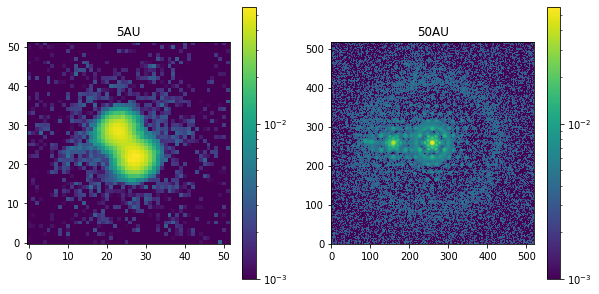

In [130]:
# Gaussian noise
noise1 =  np.random.normal(loc=0, scale=0.001, size=conv_image1.shape)
noisy1 = conv_image1 + noise1
noise2 =  np.random.normal(loc=0, scale=0.000002, size=conv_image2.shape)
noisy2 = conv_image2 + noise2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
im1=ax1.imshow(noisy1, cmap=cmap, norm=LogNorm(vmin=1e-3))
ax1.set_title("5AU")
fig.colorbar(im1, ax=ax1)

im2=ax2.imshow(noisy2, cmap=cmap, norm=LogNorm(vmin=1e-8))
ax2.set_title("50AU")
fig.colorbar(im1, ax=ax2)